In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install pafy youtube-dl moviepy

In [ ]:
!pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import cv2
import math
import pafy
import random
import numpy as np
import datetime as dt
import tensorflow as tf
#from moviepy.editor import *
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
!wget -nc --no-check-certificate http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
!unrar x hmdb51_org.rar -inul -y

File ‘hmdb51_org.rar’ already there; not retrieving.



In [ ]:
image_height, image_width = 64, 64
max_images_per_class = 6000
seq_len = 70
dataset_directory = "/content/drive/MyDrive/hmdb51_org"
classes_list = ["climb_stairs", "fall_floor", "run", "sit","stand","walk"]

model_output_size = len(classes_list)

In [ ]:
def frames_extraction(video_path):
    # Empty List declared to store video frames
    frames_list = []
    
    # Reading the Video File Using the VideoCapture
    video_reader = cv2.VideoCapture(video_path)

    # Iterating through Video Frames
    while True:

        # Reading a frame from the video file 
        success, frame = video_reader.read() 

        # If Video frame was not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Appending the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Closing the VideoCapture object and releasing all resources. 
    video_reader.release()

    # returning the frames list 
    return frames_list

In [ ]:
def create_dataset():

    # Declaring Empty Lists to store the features and labels values.
    temp_features = [] 
    features = []
    labels = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        print(f'Extracting Data of Class: {class_name}')
        
        # Getting the list of video files present in the specific class name directory
        files_list = os.listdir(os.path.join(dataset_directory, class_name))

        # Iterating through all the files present in the files list
        for file_name in files_list:

            # Construct the complete video path
            video_file_path = os.path.join(dataset_directory, class_name, file_name)

            # Calling the frame_extraction method for every video file path
            frames = frames_extraction(video_file_path)

            # Appending the frames to a temporary list.
            temp_features.extend(frames)
        
        # Adding randomly selected frames to the features list
        features.extend(random.sample(temp_features, max_images_per_class))

        # Adding Fixed number of labels to the labels list
        labels.extend([class_index] * max_images_per_class)
        
        # Emptying the temp_features list so it can be reused to store all frames of the next class.
        temp_features.clear()

    # Converting the features and labels lists to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  

    return features, labels

In [ ]:
features, labels = create_dataset()

Extracting Data of Class: climb_stairs
Extracting Data of Class: fall_floor
Extracting Data of Class: run
Extracting Data of Class: sit
Extracting Data of Class: stand
Extracting Data of Class: walk


In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.2, shuffle = True, random_state = seed_constant)

In [ ]:
def create_model():
  model = Sequential()  #Model initiated and layers added whilst specifying hyperparameters

  model.add(ConvLSTM2D(filters = 64, kernel_size = (3, 3), return_sequences = False, data_format = "channels_last", input_shape = (seq_len, image_height, image_width, 3)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'))
  model.add(Dropout(0.2))

  model.add(Flatten())

  model.add(Dense(256, activation="relu"))
  model.add(Dense(256, activation="relu"))
  model.add(Dropout(0.3))

  model.add(Dense(6, activation = "softmax"))
  model.summary()  #Print summary of model

  return model

model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 62, 62, 64)        154624    
                                                                 
 dropout (Dropout)           (None, 62, 62, 64)        0         
                                                                 
 conv2d (Conv2D)             (None, 60, 60, 128)       73856     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60, 128)       0         
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                                 
 dense (Dense)               (None, 256)               117965056 
                                                                 
 dense_1 (Dense)             (None, 256)               6

In [ ]:
def create_model():  #Create NN
    model = Sequential() #Keras sequential model

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))   #Add various layers
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(288, activation = 'relu'))
    model.add(Dense(288, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    model.summary()  #Show model summary

    return model


model = create_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 conv2d_4 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 conv2d_5 (Conv2D)           (None, 54, 54, 64)        36928     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 64)       256       
 ormalization)                                                   
                                                      

In [ ]:
# Let's create a function that will construct our model
def create_model():  #Create NN
    model = Sequential() #Keras sequential model

    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', input_shape = (image_height, image_width, 3)))   #Add various layers
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(288, activation = 'relu'))
    model.add(Dense(288, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dense(model_output_size, activation = 'softmax'))

    model.summary()  #Show model summary

    return model


model = create_model()


print("Model Created Successfully!")

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 conv2d_8 (Conv2D)           (None, 58, 58, 64)        36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 56, 56, 64)        36928     
                                                                 
 conv2d_10 (Conv2D)          (None, 54, 54, 64)        36928     
                                                                 
 batch_normalization_2 (Batc  (None, 54, 54, 64)       256       
 hNormalization)                                                 
                                                      

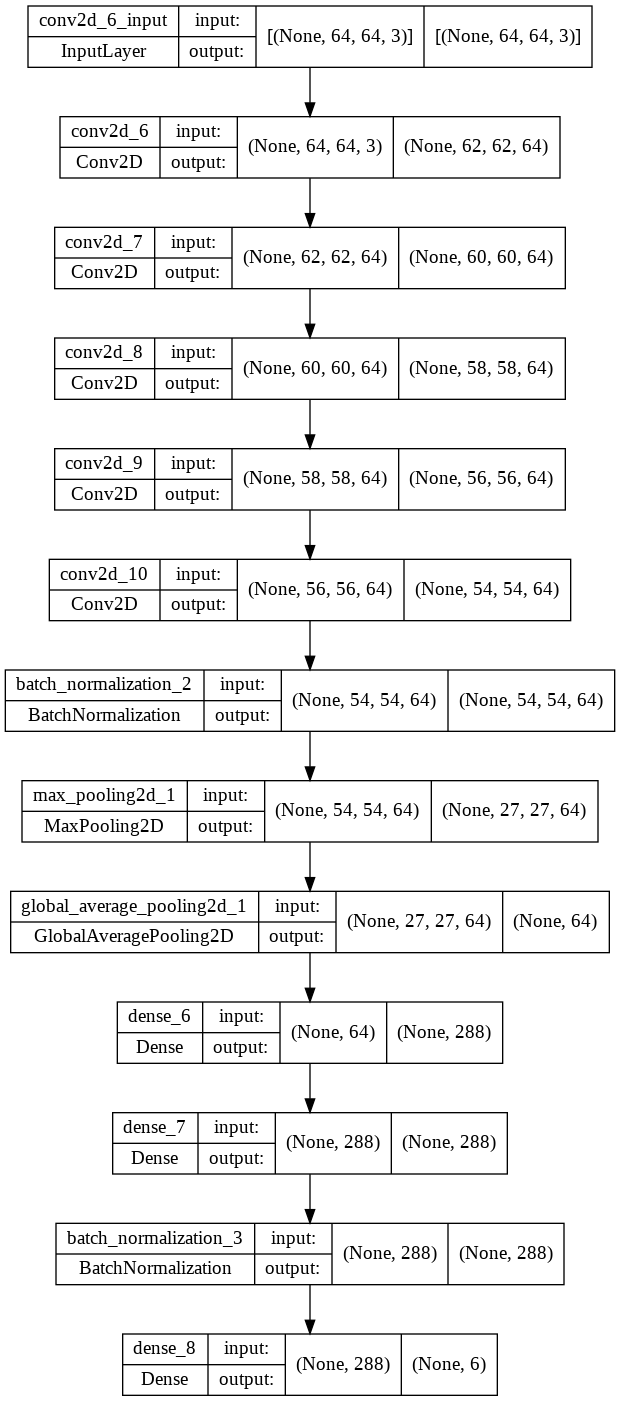

In [ ]:
plot_model(model, to_file = 'model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

In [ ]:
import tensorflow

In [ ]:
tf.reshape(data, [25, 25])

In [ ]:
opt = tensorflow.keras.optimizers.SGD(lr=0.001)    #Specify training algorithm and learning rate
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])  #Specify Loss and Accuracy metrics as well


In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss', patience = 10, mode = 'min', restore_best_weights = True) #Add early stopping by specifying patience value; wait for x amount of epochs where no improvement is seen before reverting to best weights
callbacks = [earlystop]
 
history = model.fit(x = features_train, y = labels_train, epochs=40, batch_size = 8 , shuffle=True, validation_split=0.2, callbacks=callbacks) #Fit model, specify number of epochs, validation % of training set, batch size 


RuntimeError: ignored

In [ ]:
# Adding the Early Stopping Callback to the model which will continuously monitor the validation loss metric for every epoch.
# If the models validation loss does not decrease after 15 consecutive epochs, the training will be stopped and the weight which reported the lowest validation loss will be retored in the model.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

# Adding loss, optimizer and metrics values to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start Training
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 50, batch_size = 32 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

Epoch 1/50
720/720 [==============================] - 25s 33ms/step - loss: 0.0384 - accuracy: 0.9884 - val_loss: 0.1667 - val_accuracy: 0.9554
Epoch 2/50
720/720 [==============================] - 23s 32ms/step - loss: 0.0313 - accuracy: 0.9893 - val_loss: 0.1863 - val_accuracy: 0.9550
Epoch 3/50
720/720 [==============================] - 23s 32ms/step - loss: 0.0323 - accuracy: 0.9894 - val_loss: 0.2612 - val_accuracy: 0.9368
Epoch 4/50
720/720 [==============================] - 23s 32ms/step - loss: 0.0321 - accuracy: 0.9897 - val_loss: 0.2626 - val_accuracy: 0.9325
Epoch 5/50
720/720 [==============================] - 23s 32ms/step - loss: 0.0346 - accuracy: 0.9883 - val_loss: 0.1474 - val_accuracy: 0.9632
Epoch 6/50
720/720 [==============================] - 23s 32ms/step - loss: 0.0216 - accuracy: 0.9926 - val_loss: 0.1937 - val_accuracy: 0.9550
Epoch 7/50
720/720 [==============================] - 23s 32ms/step - loss: 0.0371 - accuracy: 0.9879 - val_loss: 0.1734 - val_accuracy:

In [ ]:
model_evaluation_history = model.evaluate(features_test, labels_test)

225/225 [==============================] - 2s 9ms/step - loss: 0.1447 - accuracy: 0.9696


In [ ]:
model.save('Model.h5')
print('Model Saved!')

Model Saved!


In [ ]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

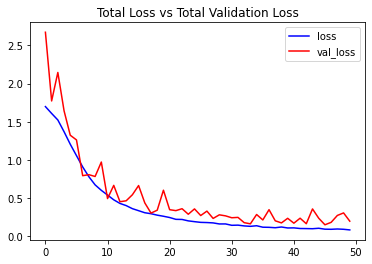

In [ ]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

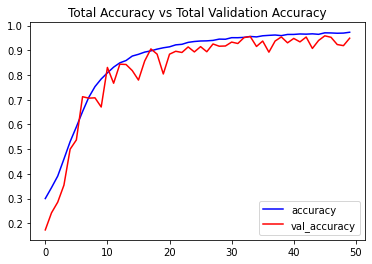

In [ ]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
output_directory = '/content/drive/MyDrive/4K'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
#video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', output_directory)
video_title = 'test'
# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'

In [ ]:
def predict_on_live_video(video_file_path, output_file_path, window_size):

    # Initialize a Deque Object with a fixed size which will be used to implement moving/rolling average functionality.
    predicted_labels_probabilities_deque = deque(maxlen = window_size)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting the width and height of the video 
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Writing the Overlayed Video Files Using the VideoWriter Object
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 24, (original_video_width, original_video_height))

    while True: 

        # Reading The Frame
        status, frame = video_reader.read() 

        if not status:
            break

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_deque.append(predicted_labels_probabilities)

        # Assuring that the Deque is completely filled before starting the averaging process
        if len(predicted_labels_probabilities_deque) == window_size:

            # Converting Predicted Labels Probabilities Deque into Numpy array
            predicted_labels_probabilities_np = np.array(predicted_labels_probabilities_deque)

            # Calculating Average of Predicted Labels Probabilities Column Wise 
            predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

            # Converting the predicted probabilities into labels by returning the index of the maximum value.
            predicted_label = np.argmax(predicted_labels_probabilities_averaged)

            # Accessing The Class Name using predicted label.
            predicted_class_name = classes_list[predicted_label]
          
            # Overlaying Class Name Text Ontop of the Frame
            cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

        # Writing The Frame
        video_writer.write(frame)


        # cv2.imshow('Predicted Frames', frame)

        # key_pressed = cv2.waitKey(10)

        # if key_pressed == ord('q'):
        #     break

    # cv2.destroyAllWindows()

    
    # Closing the VideoCapture and VideoWriter objects and releasing all resources held by them. 
    video_reader.release()
    video_writer.release()

In [ ]:
# Setting sthe Widow Size which will be used by the Rolling Averge Proces
window_size = 1

# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction.
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

In [ ]:
# Setting the Widow Size which will be used by the Rolling Averge Process
window_size = 25

# Construting The Output YouTube Video Path
output_video_file_path = f'{output_directory}/{video_title} -Output-WSize {window_size}.mp4'

# Calling the predict_on_live_video method to start the Prediction and Rolling Averge Process
predict_on_live_video(input_video_file_path, output_video_file_path, window_size)

# Play Video File in the Notebook
VideoFileClip(output_video_file_path).ipython_display(width = 700)

In [ ]:
def make_average_predictions(video_file_path, predictions_frames_count):
    
    # Initializing the Numpy array which will store Prediction Probabilities
    predicted_labels_probabilities_np = np.zeros((predictions_frames_count, model_output_size), dtype = np.float)

    # Reading the Video File using the VideoCapture Object
    video_reader = cv2.VideoCapture(video_file_path)

    # Getting The Total Frames present in the video 
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculating The Number of Frames to skip Before reading a frame
    skip_frames_window = video_frames_count // predictions_frames_count

    for frame_counter in range(predictions_frames_count): 

        # Setting Frame Position
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading The Frame
        _ , frame = video_reader.read() 

        # Resize the Frame to fixed Dimensions
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Passing the Image Normalized Frame to the model and receiving Predicted Probabilities.
        predicted_labels_probabilities = model.predict(np.expand_dims(normalized_frame, axis = 0))[0]

        # Appending predicted label probabilities to the deque object
        predicted_labels_probabilities_np[frame_counter] = predicted_labels_probabilities

    # Calculating Average of Predicted Labels Probabilities Column Wise 
    predicted_labels_probabilities_averaged = predicted_labels_probabilities_np.mean(axis = 0)

    # Sorting the Averaged Predicted Labels Probabilities
    predicted_labels_probabilities_averaged_sorted_indexes = np.argsort(predicted_labels_probabilities_averaged)[::-1]

    # Iterating Over All Averaged Predicted Label Probabilities
    for predicted_label in predicted_labels_probabilities_averaged_sorted_indexes:

        # Accessing The Class Name using predicted label.
        predicted_class_name = classes_list[predicted_label]

        # Accessing The Averaged Probability using predicted label.
        predicted_probability = predicted_labels_probabilities_averaged[predicted_label]

        print(f"CLASS NAME: {predicted_class_name}   AVERAGED PROBABILITY: {(predicted_probability)}")
    
    # Closing the VideoCapture Object and releasing all resources held by it. 
    video_reader.release()

In [ ]:
import moviepy.editor as mp

video = mp.VideoFileClip(input_video_file_path)
#mp3 = video.audio
#if mp3 is not None:
#    mp3.write_audiofile("vid_audio.mp3")
#mp3_size =  os.path.getsize("vid_audio.mp3")
vid_size = os.path.getsize(input_video_file_path)
duration = video.duration


bitrate = int((((vid_size)/duration)/1024*8))
print(bitrate)

45


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
output_directory = '/content/drive/MyDrive/4K'
os.makedirs(output_directory, exist_ok = True)

# Downloading a YouTube Video
#video_title = download_youtube_videos('https://www.youtube.com/watch?v=8u0qjmHIOcE', output_directory)
video_title = 'br15k'
# Getting the YouTube Video's path you just downloaded
input_video_file_path = f'{output_directory}/{video_title}.mp4'



import moviepy.editor as mp

video = mp.VideoFileClip(input_video_file_path)
#mp3 = video.audio
#if mp3 is not None:
#    mp3.write_audiofile("vid_audio.mp3")
#mp3_size =  os.path.getsize("vid_audio.mp3")
vid_size = os.path.getsize(input_video_file_path)
duration = video.duration


bitrate = int((((vid_size)/duration)/1024*8))
print(bitrate)

# Calling The Make Average Method To Start The Process
make_average_predictions(input_video_file_path, 50)

# Play Video File in the Notebook
VideoFileClip(input_video_file_path).ipython_display(width = 700)

22
CLASS NAME: fall_floor   AVERAGED PROBABILITY: 0.8860008537769317
CLASS NAME: walk   AVERAGED PROBABILITY: 0.11399219535291195
CLASS NAME: stand   AVERAGED PROBABILITY: 6.6811555007006974e-06
CLASS NAME: sit   AVERAGED PROBABILITY: 2.4806874193927797e-07
CLASS NAME: run   AVERAGED PROBABILITY: 3.568782709351126e-08
CLASS NAME: climb_stairs   AVERAGED PROBABILITY: 1.307334539291105e-08


100%|██████████| 126/126 [00:01<00:00, 64.97it/s]
